# **Python for Finance -- Session 3 -- Assignment**
---
<img src="http://www.doc.ic.ac.uk/~afd/images/logo_imperial_college_london.png" align = "left" width=200>
 <br><br><br><br>

- Platform: Tested on MACOS with Catalina

## Data Import and visualisation

### Import a history of time series of your stock of your choice and plot a histogram of the returns using the sns library.

In [36]:
import pandas as pd
import seaborn as sns
import yahoo_fin.stock_info as si

In [43]:
aapl = si.get_data("aapl")[["adjclose"]].pct_change().dropna()

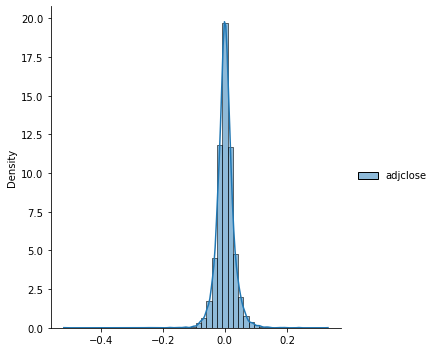

In [59]:
sns.displot(aapl
            , stat="density"
            , bins=50
#             , stat="probability"
#             , kind = "kde"
            , kde = True
           )

### Using yahoo_fin, create a dictionary where each key is a ticker of the S&P500 and the value is a table containing all the daily values of the ticker between 1/1/2018 and 5/1/2018

> Hint: you may want to also use the `try` command to handle any possible errors.

In [60]:
import yahoo_fin.stock_info as si

In [61]:
listTickers = si.tickers_sp500()

In [66]:
spAll = {}
tickersNotWorking = []

for ticker in listTickers:
    try:
        temp = si.get_data(ticker, start_date="01/01/2017", end_date="12/31/2017")
        spAll[ticker] = temp
    except:
        tickersNotWorking.append(ticker)        

In [67]:
tickersNotWorking

['BF.B',
 'BRK.B',
 'CARR',
 'CTVA',
 'DOW',
 'FOX',
 'FOXA',
 'LUMN',
 'OTIS',
 'VIAC',
 'VNT']

## Webscraping

Write a procedure/function importHistData(crypto, startDate, endDate), 
which fetches a cryptocurrency (indicated by its ticker "crypto"), imports its daily end-of-day values 
between startDate, endDate, and plots it.

The data is available on the website https://coinmarketcap.com/currencies/

**Hints and Warnings**:
- The input date format should be "datetime(YYYY, MM, DD)"
- You need to use the Python packages beautifulSoup, requests, datetime, matplotlib
- Examples of cryptocurrency tickers: "bitcoin", "ethereum-classic", "litecoin", "tezos", "kyber-network", "chainlink"
- Be careful with date and value formats

In [300]:
from bs4 import BeautifulSoup
from datetime import datetime

import matplotlib.pylab as plt
import matplotlib.ticker as plticker

In [304]:
# Selenium is needed because the pages of CoinMarketCap are loaded dynamically, via Javascript
from selenium import webdriver

In [313]:
# The browser that we will use for Selenium is 'headless Chrome'.
# The compatible driver can be downloaded from here:
# http://chromedriver.storage.googleapis.com/index.html

# More info can be found here:
# https://stackoverflow.com/questions/28307469/chrome-driver-needs-to-be-available-in-the-path-error-on-mac

# Currently the installed version of Chrome on this computer is:
!/Applications/Google\ Chrome.app/Contents/MacOS/Google\ Chrome --version

Google Chrome 86.0.4240.193 


In [314]:
# After downloading the correct version of the driver
# Edit the path below in order to point to the executable:
pathToChromeDriver = '/usr/local/bin/chromedriver'

In [315]:
def importHistData(crypto, startDate, endDate):
    
    sDate   = startDate.strftime("%Y%m%d")
    eDate   = endDate.strftime("%Y%m%d")
    url     = "https://coinmarketcap.com/currencies/{0}/historical-data/?start={1}&end={2}"
    url     = url.format(crypto, sDate, eDate)
    print(url)
    
    options = webdriver.ChromeOptions()
    options.add_argument('headless')
    browser = webdriver.Chrome(pathToChromeDriver, options=options)
    browser.get(url)
    
    html = browser.page_source
    soup = BeautifulSoup(html, 'lxml')
    table = soup.find_all('div', class_="cmc-table__table-wrapper-outer")[2]
    
    head_data = table.findChildren('thead')[0]
    headers = [th.text.strip() for th in head_data.findChildren('th')]
    headers = [header.replace('*', '') for header in headers]

    body_data = table.findChildren('tbody')[0]
    rows = [[td.text.strip() for td in tr.findChildren('td')] for tr in body_data.findChildren('tr')]
    dates = [datetime.strptime(row[0], '%b %d, %Y') for row in rows]
    closeValues = [float(r[4].replace(',', '')) for r in rows]
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(dates, closeValues, 'b')
    loc = plticker.MultipleLocator(base=60)
    ax.xaxis.set_major_locator(loc)
    plt.title("Evolution of %s" %crypto)
    plt.show()

In [318]:
listCryptos = ["bitcoin", "ethereum-classic", "litecoin", "tezos", "kyber-network", "chainlink", "0x"]

# crypto = listCryptos[0]
# startDate = datetime(2017, 1, 1)
# endDate = datetime(2018, 12, 31)

crypto = listCryptos[1]
startDate = datetime(2020, 1, 1)
endDate = datetime.today()

https://coinmarketcap.com/currencies/ethereum-classic/historical-data/?start=20200101&end=20201111


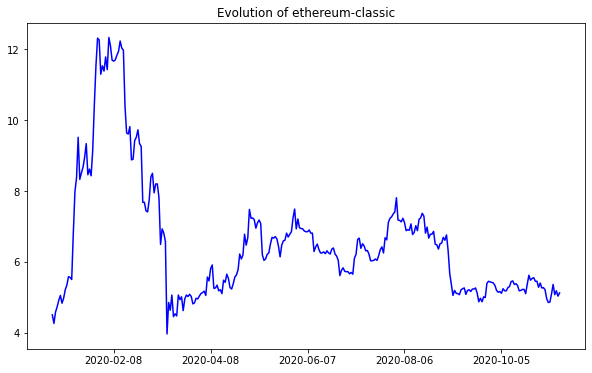

In [319]:
importHistData (crypto, startDate, endDate)

## Application to option pricing

Using the `bokeh` library, analyse graphically the influence of the maturity $T$ and the volatility parameter $\sigma$ on the function $K\mapsto C^{\mathrm{BS}}(S_0, K, T, \sigma)$, for some fixed $S_0 = 100$, as $K$ ranges from $50$ to $100$. We assume no interest and no dividend.

### Import the `bokeh` libraries

In [329]:
import bokeh.plotting
import bokeh.io
import bokeh.plotting.figure as bk_figure
from bokeh.io import curdoc, show
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import Slider, TextInput
from bokeh.io import output_notebook # enables plot interface in J notebook
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler
# from bokeh.layouts import row, widgetbox # widgetbox will be deprecated
from bokeh.layouts import row, column


import numpy as np

bokeh.io.output_notebook()

Loading BokehJS ...

### Define the Black-Scholes Call price function

In [322]:
from scipy.stats import norm

In [323]:
def BSCall(S0, K, sigma, t, T):
    '''
    #Inputs:
    S0: initial stock price
    K: strike
    sigma: instantaneous volatility
    T: time to maturity
    
    #Output:
    Black-Scholes Call price
    '''
    
    tau = T - t
    sigmtau = sigma*np.sqrt(tau)
    k = np.log(K/S0)
    dp = -k / sigmtau + 0.5*sigmtau
    dm = dp - sigmtau
    
    return S0*(norm.cdf(dp) - np.exp(k)*norm.cdf(dm))

In [324]:
S0, K, sigma, t, T = 100., 100., 0.2, 0., 1.

print("Black-Scholes Call option price:", BSCall(S0,K,sigma,t,T))

Black-Scholes Call option price: 7.965567455405798


### Set up `bokeh` plot

In [325]:
# Set up data

n = 200
KK = np.linspace(0.1*S0, 3.*S0, n)
cc = np.array([BSCall(S0,K,sigma,t,T) for K in KK])
source = ColumnDataSource(data=dict(x=KK, y=cc))

In [327]:
# Set up plot

plot = bk_figure(
                  plot_height = 400
                , plot_width  = 400
                , title       = "Black-Scholes Call Price function"
                , tools       = "crosshair,pan,reset,save,wheel_zoom"
                , x_range     = [np.min(KK), np.max(KK)]
                , y_range     = [np.min(cc), np.max(cc)]
                )

plot.line('x', 'y'
                    , source     = source
                    , line_width = 3
                    , line_alpha = 0.6
         )

vol = Slider(
              title = "Volatility"
            , value = sigma
            , start = 0.01
            , end   = 1.
            , step  = 0.02
            )

maturity = Slider(
                  title = "Maturity"
                , value = T
                , start = 0.1
                , end   = 5.
                , step  = 0.1
                )

def update_data(attrname, old, new):
    # Get the current slider values
    mat = maturity.value
    v = vol.value
    # Generate the new curve
    newcc = np.array([BSCall(S0,K,v,0.,mat) for K in KK])

    source.data = dict(x=KK, y=newcc)

for w in [vol, maturity]:
    w.on_change('value', update_data)


In [330]:
# Set up layouts and add to document

inputs = column(vol, maturity)
layout = row(plot, column(vol, maturity))

def modify_doc(doc):
    doc.add_root(row(layout, width=800))
    doc.title = "Sliders"

handler = FunctionHandler(modify_doc)
show(Application(handler))

In [320]:
### ### ###
### END ###
### ### ###